# Variational Autoencoder

Autoencoders are neural network architectures used to:
* Encoder data - Create lower-dimension representations of input data.
* Decode data - From these lower-dimension representations, re-create the input data.

Variational autoencoders are a form of autoencoder that learns latent (lower-dimensional) *distribution* of inputs' mean and standard deviation. There is then a **sampling** layer after the latent encoding layer that samples from these mean and standard deviation distributions, outputting new, realistic synthetic observation.

In [373]:
# Commented out for non-Colab user

# # re upload files everytime run

# from google.colab import files

# uploaded = files.upload()

### Options

* `pass_only` - True if only want to generate normative data
* `scale` - True if want to scale all columns to (0,1) scale
* `multi-activation` - True if want output layer to have multiple activation functions
* `transform` - True if you want to transform columns to approximate normal distributions before going into the VAE
* `freqs_only` - True if you only want to produce frequencies and not other control variables
* `latent_dim` - Number of latent dimensions for the VAE

In [374]:
pass_only = True
scale = True
multi_activation = True
transform = False
freqs_only = True
latent_dim = 32

Adjustment

In [375]:
if freqs_only is True:
    if transform is True:
        transform = False
        print("Transform is set to True but this is not necessary as you are only producing frequencies, which are already between 0 and 1.\n ---> Setting transform to False")
    if multi_activation is True:
        multi_activation = False
        print("Multi_activation is set to True but this is not necessary as you are only producing frequencies, which are already between 0 and 1 - only need sigmoid function.\n ---> Setting multi_activation to False")


Multi_activation is set to True but this is not necessary as you are only producing frequencies, which are already between 0 and 1 - only need sigmoid function.
 ---> Setting multi_activation to False


The best combination found was:
* `pass_only` = True
* `scale` = True
* `multi_activation` = True
* `transform` = False
* `freqs_only` = False

Even if we are looking to only produce frequencies, excluding the control variables seems to produce more sporadic results when we attempt generate only normative data (pass_only = True). The main hypothesis for this is that including the control variables in the generative model allows it to learn inherent relationships between absorbance values and various variables. This would not be captured if the control variables are not included in the generative model.

By including the control variables, scaling them to be between 0 and 1 before being encoded leads to much better results, even if their activation functions allow values outside that range. Having said so, setting multi_activation to True is still important, as using a sigmoid output activation for the control variables which can take values outside (0,1) leads to a gross over-generalisation, even after inverse scaling.

# Environment Set-up

## Libraries

In [376]:
## Load libraries

# Data manipulation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
print('numpy: %s' % np.__version__)

# Deep learning
from tensorflow import concat
from tensorflow import keras
print('Tensorflow/Keras: %s' % keras.__version__)

from keras.models import Model
from keras import Input
from keras.layers import Dense, Lambda
from tensorflow.keras.utils import plot_model
from keras import backend as K

# Plotting
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white' # Since I use a dark IDE
print('matplotlib: %s' % matplotlib.__version__)

import graphviz
print('graphviz: %s' % graphviz.__version__)

import plotly
import plotly.express as px
print('plotly: %s' % plotly.__version__)

import seaborn as sns

# Other
import sys
import os

main_dir=os.path.dirname(sys.path[0])
print('main dir: %s' % main_dir)

numpy: 1.22.3
Tensorflow/Keras: 2.9.0
matplotlib: 3.5.1
graphviz: 0.20.1
plotly: 5.10.0
main dir: /Users/benjamintan/Library/CloudStorage/OneDrive-TheUniversityofWesternAustralia/Master of Data Science/Year 2/Semester 2/CITS5553/CITS5553-Capstone-Project/Generative Models


## Loading Data

In [377]:
import pandas as pd

full_data = pd.read_csv('wba_data_CLEAN.csv')
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

X = pd.concat([X_train, y_train], axis=1)
X_valid = pd.concat([X_test, y_test], axis=1)
full_data = full_data[X.columns]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(191, 120)
(191, 1)
(48, 120)
(48, 1)


In [378]:
# List of frequencies and control variables
freq_cols = [c for c in X.columns if c[:2] == "f("]
cont_cols = [c for c in X.columns if c[:2] != "f("]

## Pre-Processing

### Deleting Fail Observations

Delete all the 'failed' observations if the `pass_only` options is set to True.

In [379]:
if pass_only:
    X = X[X['OverallPoF'] == 0]
    X_valid = X_valid[X_valid['OverallPoF'] == 0]

    y_train = y_train[y_train['OverallPoF'] == 0]
    y_test = y_test[y_test['OverallPoF'] == 0]

### Column Re-Ordering

Re-ordering columns so that the relevant activations functions can be used on the relevant columns. They will be categorised, in order --  Variables which:
1. Lie on real number line (floating-point values that can be both positive and negative)
2. Can be any **positive** number (positive floating-point values)
3. Can only be within (0,1) range (including binary variables)

    * SC can only be positive
    * Gender, TympType, EarCoded, OverallPoF all binary
    * Frequencies' WBA values must lie between 0 and 1
    * The remaining variables lie on the real number line

The VAE is configure to automatically detect variables in this order and apply the activation functions accordingly.

In [380]:
# List of all control variables
cont_cols = [c for c in X.columns if c[:2] != "f("]

# List of all binary columns
bin_cols = ["Gender", "TympType", "Ear coded", "OverallPoF"]

pos_cols = ["SC", "ECV"]

# Remove binary columns from cont_cols
for bin_col in bin_cols:
    cont_cols.remove(bin_col)

for pos_col in pos_cols:
    cont_cols.remove(pos_col)

# Add them back at the end
cont_cols = cont_cols + pos_cols + bin_cols

# Re-order columns
X = X[cont_cols + freq_cols]
X_valid = X_valid[cont_cols + freq_cols]

X[cont_cols].head()

,AgeY,TPP,OAE1,OAE1.4,OAE2,OAE2.8,OAE4,Pressure,SC,ECV,Gender,TympType,Ear coded,OverallPoF
1,9.833333,-63.0,8.1,20.8,14.7,6.9,8.3,-4,1.32,0.81,1,0,0,0
2,10.083333,-28.0,10.4,15.4,15.6,9.9,10.7,1,0.56,1.50,0,0,1,0
3,8.666667,3.0,10.6,15.1,15.0,7.8,4.0,-4,1.07,1.15,1,0,0,0
4,8.583333,-10.0,3.7,11.5,7.4,5.7,8.5,-3,0.43,1.03,1,0,0,0
5,9.750000,-11.0,21.0,28.0,27.0,16.0,20.0,-3,0.56,0.95,0,0,1,0


### Scaling

Scaling all data to (0,1) range if the option is set.

Neural networks work better with data all within this range. 

In [381]:
from sklearn.preprocessing import MinMaxScaler

if scale is True:
    # Scale all columns to (0,1) range
    scaler = MinMaxScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X))
    X_test_scaled = pd.DataFrame(scaler.fit_transform(X_valid))
    X_train_scaled.columns = X.columns
    X_test_scaled.columns = X.columns
else:
    X_train_scaled = X.copy()
    X_test_scale = X_valid.copy()

### Data Transformation

We experiment with  transforming the distributions of variables to approximate normality.

VAEs use a Gaussian distribution to sample from. Although theoretically non-linear transformations of the decoder may be able to 'map' the normal distribution to other distributions, making distributions normal in the first place may yield performance improvements, especially because we are mapping so many variables to a significantly smaller number of latent distributions.

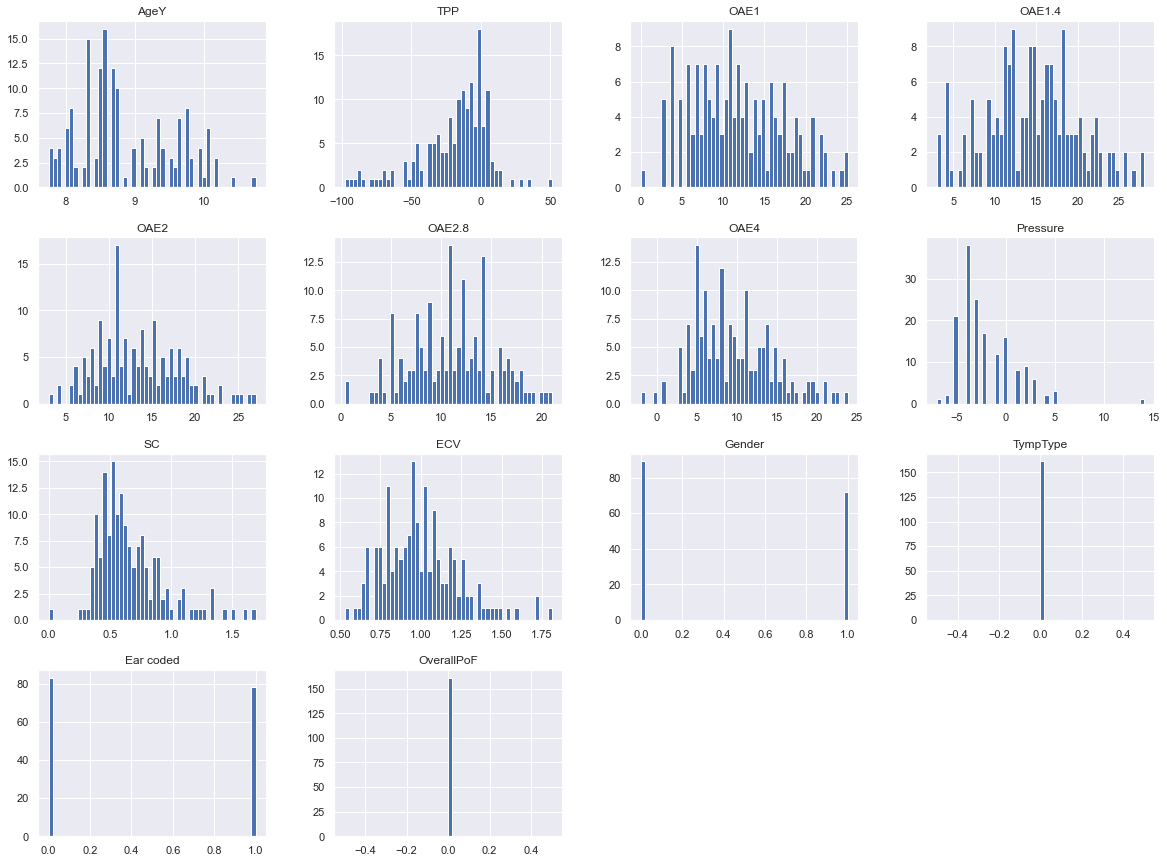

In [430]:
X[cont_cols].hist(bins=50, figsize=(20,15))
plt.show();

We can see that:
* TPP is left-skewed
* SC is right-skewed
* Pressure is right-skewed
* OAEs tend to be normally distributed 


Making copy of data to experiment with

In [431]:
# Experimental transformation functions
from math import exp
from math import log
from math import sqrt

# Making copy of dataframe to play around with
X_transformed = X.copy(deep=True)

### Right Skewed

After manual experimentation, the following transformations made SC and Pressure approximate normal distributions:
* `SC`: Root 2
* `Pressure`: Root 4

/Users/benjamintan/miniforge3/envs/tf_env/lib/python3.8/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/benjamintan/miniforge3/envs/tf_env/lib/python3.8/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


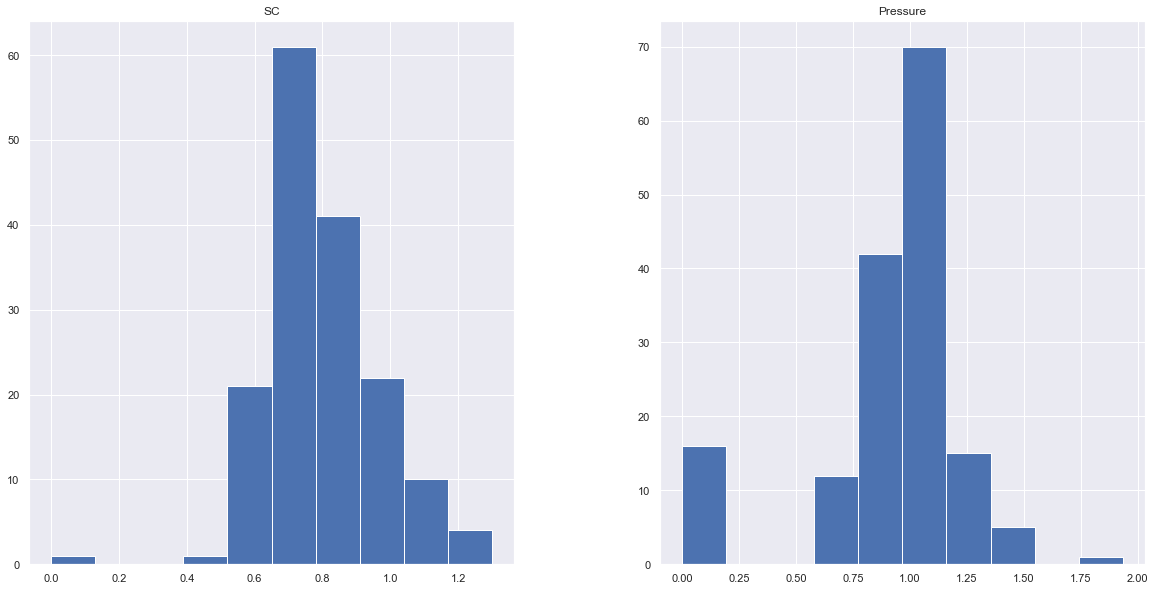

In [432]:
right_skewed = ['SC', 'Pressure']

X_transformed['SC'] = X['SC'].apply(lambda x: x**(1/2))
X_transformed['Pressure'] = X['Pressure'].apply(lambda x: x**(1/4))

X_transformed[right_skewed].hist();

### Left Skewed

After manual experimentation, the best we could get was transforming `TPP` by root 4.

The result is not perfect but it is the best we can do given our constraints (e.g. cannot do log transformations due to the 0s).

/Users/benjamintan/miniforge3/envs/tf_env/lib/python3.8/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/benjamintan/miniforge3/envs/tf_env/lib/python3.8/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


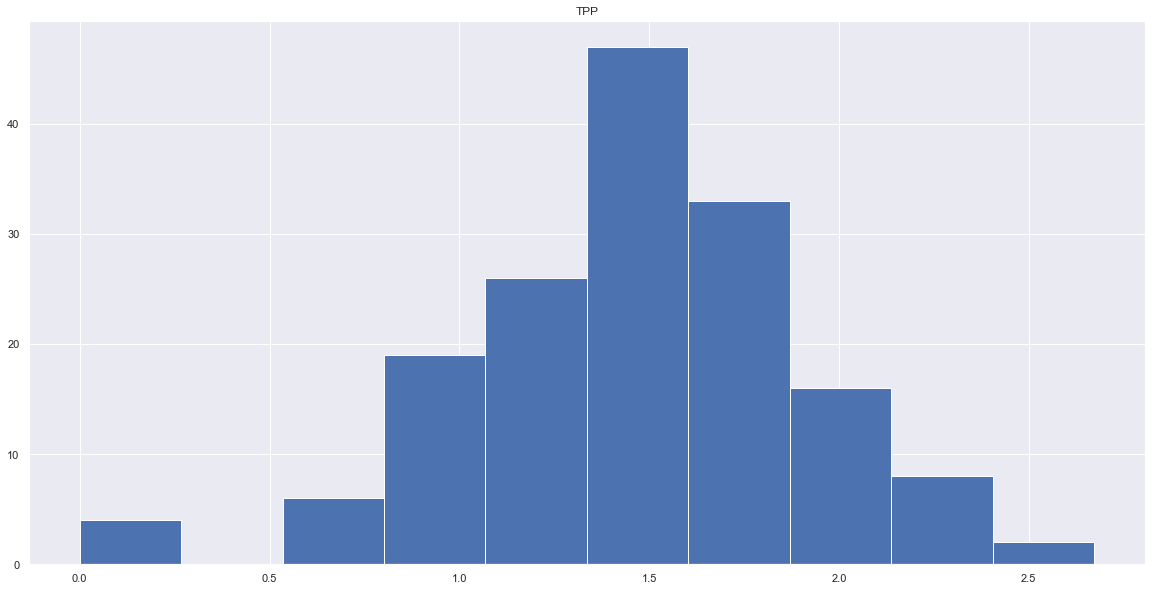

In [433]:
left_skewed = ['TPP'] # only done just in case any more left-skewed variables are added in the future

X_transformed['TPP'] = X['TPP'].apply(lambda x: x**(1/4))

X_transformed[left_skewed].hist();

### Transformation Function

Based on the above results, we will create functions to transform and un-transform our data

(Be careful to not run multiple times!)

In [434]:
def normalise(df):
    """
    Transform data based on the above results
    """
    df['SC'] = df['SC'].apply(lambda x: x**(1/2))
    df['Pressure'] = df['Pressure'].apply(lambda x: x**(1/4))
    df['TPP'] = df['TPP'].apply(lambda x: x**(1/4))
    return df

def un_normalise(df):
    """
    Reverses the normalise function
    """
    df['SC'] = df['SC'].apply(lambda x: x**2)
    df['Pressure'] = df['Pressure'].apply(lambda x: x**4)
    df['TPP'] = df['TPP'].apply(lambda x: x**4)
    return df


### Applying Transformation

Applying the above transformations if the `transformation` options is set to True.

In [435]:
if transform is True:
    X = normalise(X)
    X = normalise(X)

### Removing Non-Frequencies

Removing control variables if `freqs_only` option is set to True.

In [388]:
if freqs_only is True:
    X = X[freq_cols + ["OverallPoF"]]
    X_valid = X_valid[freq_cols + ["OverallPoF"]]

# VAE

### Sampling Layer + Reparameterization Trick

The sampling layer samples from the distributions in the latent layer. However, this makes it difficult to train the network using backpropagation. Backpropagation involves calculating the change in error/loss function with respect to changes in model weights. However, this layer involves *sampling* from distributions in the previous layer and the 'randomness' of sampling means that the aforementioned differentiation cannot be calculated. This makes the sampling layer a 'blockage' to backpropagation.\
\
To tackle this, the **reparameterization trick** is used. By making the latent vector $\mu + \sigma * \epsilon$ (i.e., multiplying $\sigma$ by $\epsilon$), where $\epsilon$ ~ Norm(0,1), a neuron is added to the sampling layer which allows backpropagation to continue through previous layers. 

In [389]:
def sampling(args):
  """
  This funciton conducts the reparameterization trick for the sampling layer
  """
  z_mean, z_log_sigma = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.) ## reparameterisation trick
  return z_mean + K.exp(z_log_sigma) * epsilon

### Encoder

The encoder takes in an *n*-dimensional input and reduces it to (`latent_dim`) latent dimensions.

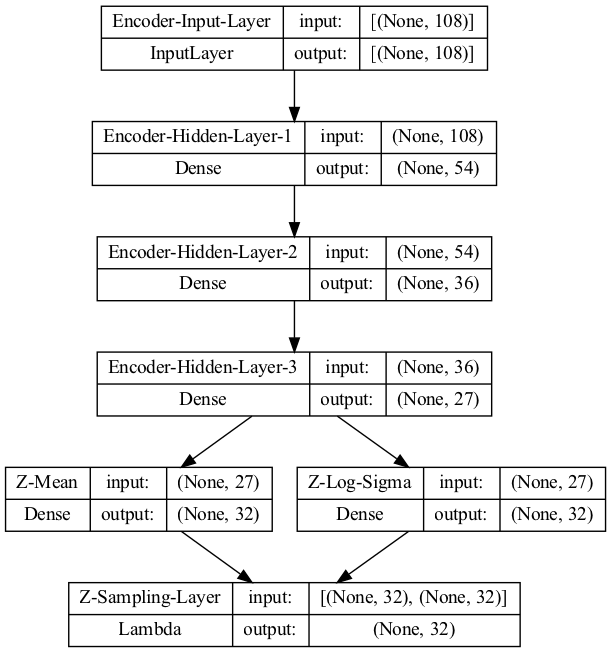

In [390]:
## Encoder
original_dim = len(X_train_scaled.columns)

# latent_dim = 2

visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')

h_enc1 = Dense(units=original_dim//2, activation='selu', name='Encoder-Hidden-Layer-1')(visible)
h_enc2 = Dense(units=original_dim//3, activation='selu', name='Encoder-Hidden-Layer-2')(h_enc1)
h_enc3 = Dense(units=original_dim//4, activation='selu', name='Encoder-Hidden-Layer-3')(h_enc2)

z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc3)
z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc3)
z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma])

encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')

plot_model(encoder, show_shapes=True, dpi=100)

### Decoder

The decoder re-constructs (a variant of, in this case) the initial input, by sampling from the mean and standard deviation distributions in the latent layer.

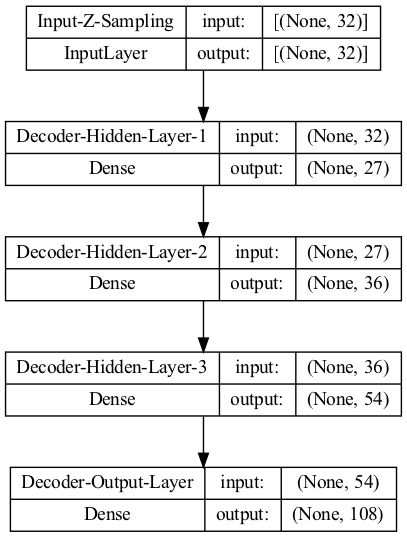

In [391]:
## Decoder
latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

h_dec = Dense(units=original_dim//4, activation='selu', name='Decoder-Hidden-Layer-1')(latent_inputs)
h_dec2 = Dense(units=original_dim//3, activation='selu', name='Decoder-Hidden-Layer-2')(h_dec)
h_dec3 = Dense(units=original_dim//2, activation='selu', name='Decoder-Hidden-Layer-3')(h_dec2)

## Multi output activation
# Linear for control variables who can take any value
# Softplus for control variables whocan take any POSITIVE value
# Sigmoid for binary variables, frequencies and any other variables that lie between 0 and 1.
if multi_activation:
    # No activation (all non-positive-only and non-binary control variables)
    output_1 = Dense(units = len(cont_cols) - len(pos_cols) - len(bin_cols), activation=None)(h_dec3)

    # SoftPlus (positive values only, any range) 
    output_2 = Dense(units = len(pos_cols), activation='softplus')(h_dec3)

    # Sigmoid (binonmial + frequencies)
    output_3 = Dense(units = len(bin_cols) + len(freq_cols), activation='sigmoid')(h_dec3)

    # Combining into one layer
    outputs = concat([output_1, output_2, output_3], axis=1)
##
else:
# Single output activation
    outputs = Dense(original_dim, activation='sigmoid', name='Decoder-Output-Layer')(h_dec3)

decoder = Model(latent_inputs, outputs, name='Decoder-Model')

plot_model(decoder, show_shapes=True, dpi=100)

In [392]:
## Autoencoder

# Reference -- From above:
### visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')

outpt = decoder(
    encoder(visible)[2] # Encode the input and take the 3rd element of the output (z-score)
    )

# Set mode parameters (number of inputs/outputs)
vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')

### Loss Function

We use mean-squared error loss (i.e., mean squared difference between encoder input and decoder output).

**KL-Divergence**\
As variational autoencoders sample from distributions with, in this case, the goal of generating *new* samples, the loss function needs to be altered for that goal. In other words, we don't want the output to be exactly the same as the input - we want features of the output to come from the same distributions as features from the input, such that the output is a realistic synthetic observation that can be used for analysis.\
Thus, we add a *Kullback-Leibler (KL) Divergence* term, which calculates the difference between **probability distributions**. 

In [393]:
## Loss Function
r_loss = original_dim * keras.losses.mse(visible, outpt) # MSE loss
kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1) # KL Divergence
vae_loss = K.mean(r_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

### Model Training

Epoch 1/25
11/11 [==============================] - 2s 54ms/step - loss: 15.7655 - val_loss: 13.1653
Epoch 2/25
11/11 [==============================] - 0s 29ms/step - loss: 10.6883 - val_loss: 11.2212
Epoch 3/25
11/11 [==============================] - 0s 27ms/step - loss: 8.8088 - val_loss: 9.9404
Epoch 4/25
11/11 [==============================] - 0s 27ms/step - loss: 7.2583 - val_loss: 9.6681
Epoch 5/25
11/11 [==============================] - 0s 27ms/step - loss: 6.9042 - val_loss: 9.3432
Epoch 6/25
11/11 [==============================] - 0s 26ms/step - loss: 5.7696 - val_loss: 8.8191
Epoch 7/25
11/11 [==============================] - 0s 31ms/step - loss: 6.0791 - val_loss: 8.2736
Epoch 8/25
11/11 [==============================] - 0s 31ms/step - loss: 5.4056 - val_loss: 8.4009
Epoch 9/25
11/11 [==============================] - 0s 30ms/step - loss: 5.3607 - val_loss: 8.9765
Epoch 10/25
11/11 [==============================] - 0s 39ms/step - loss: 5.4206 - val_loss: 8.2790
Epoch

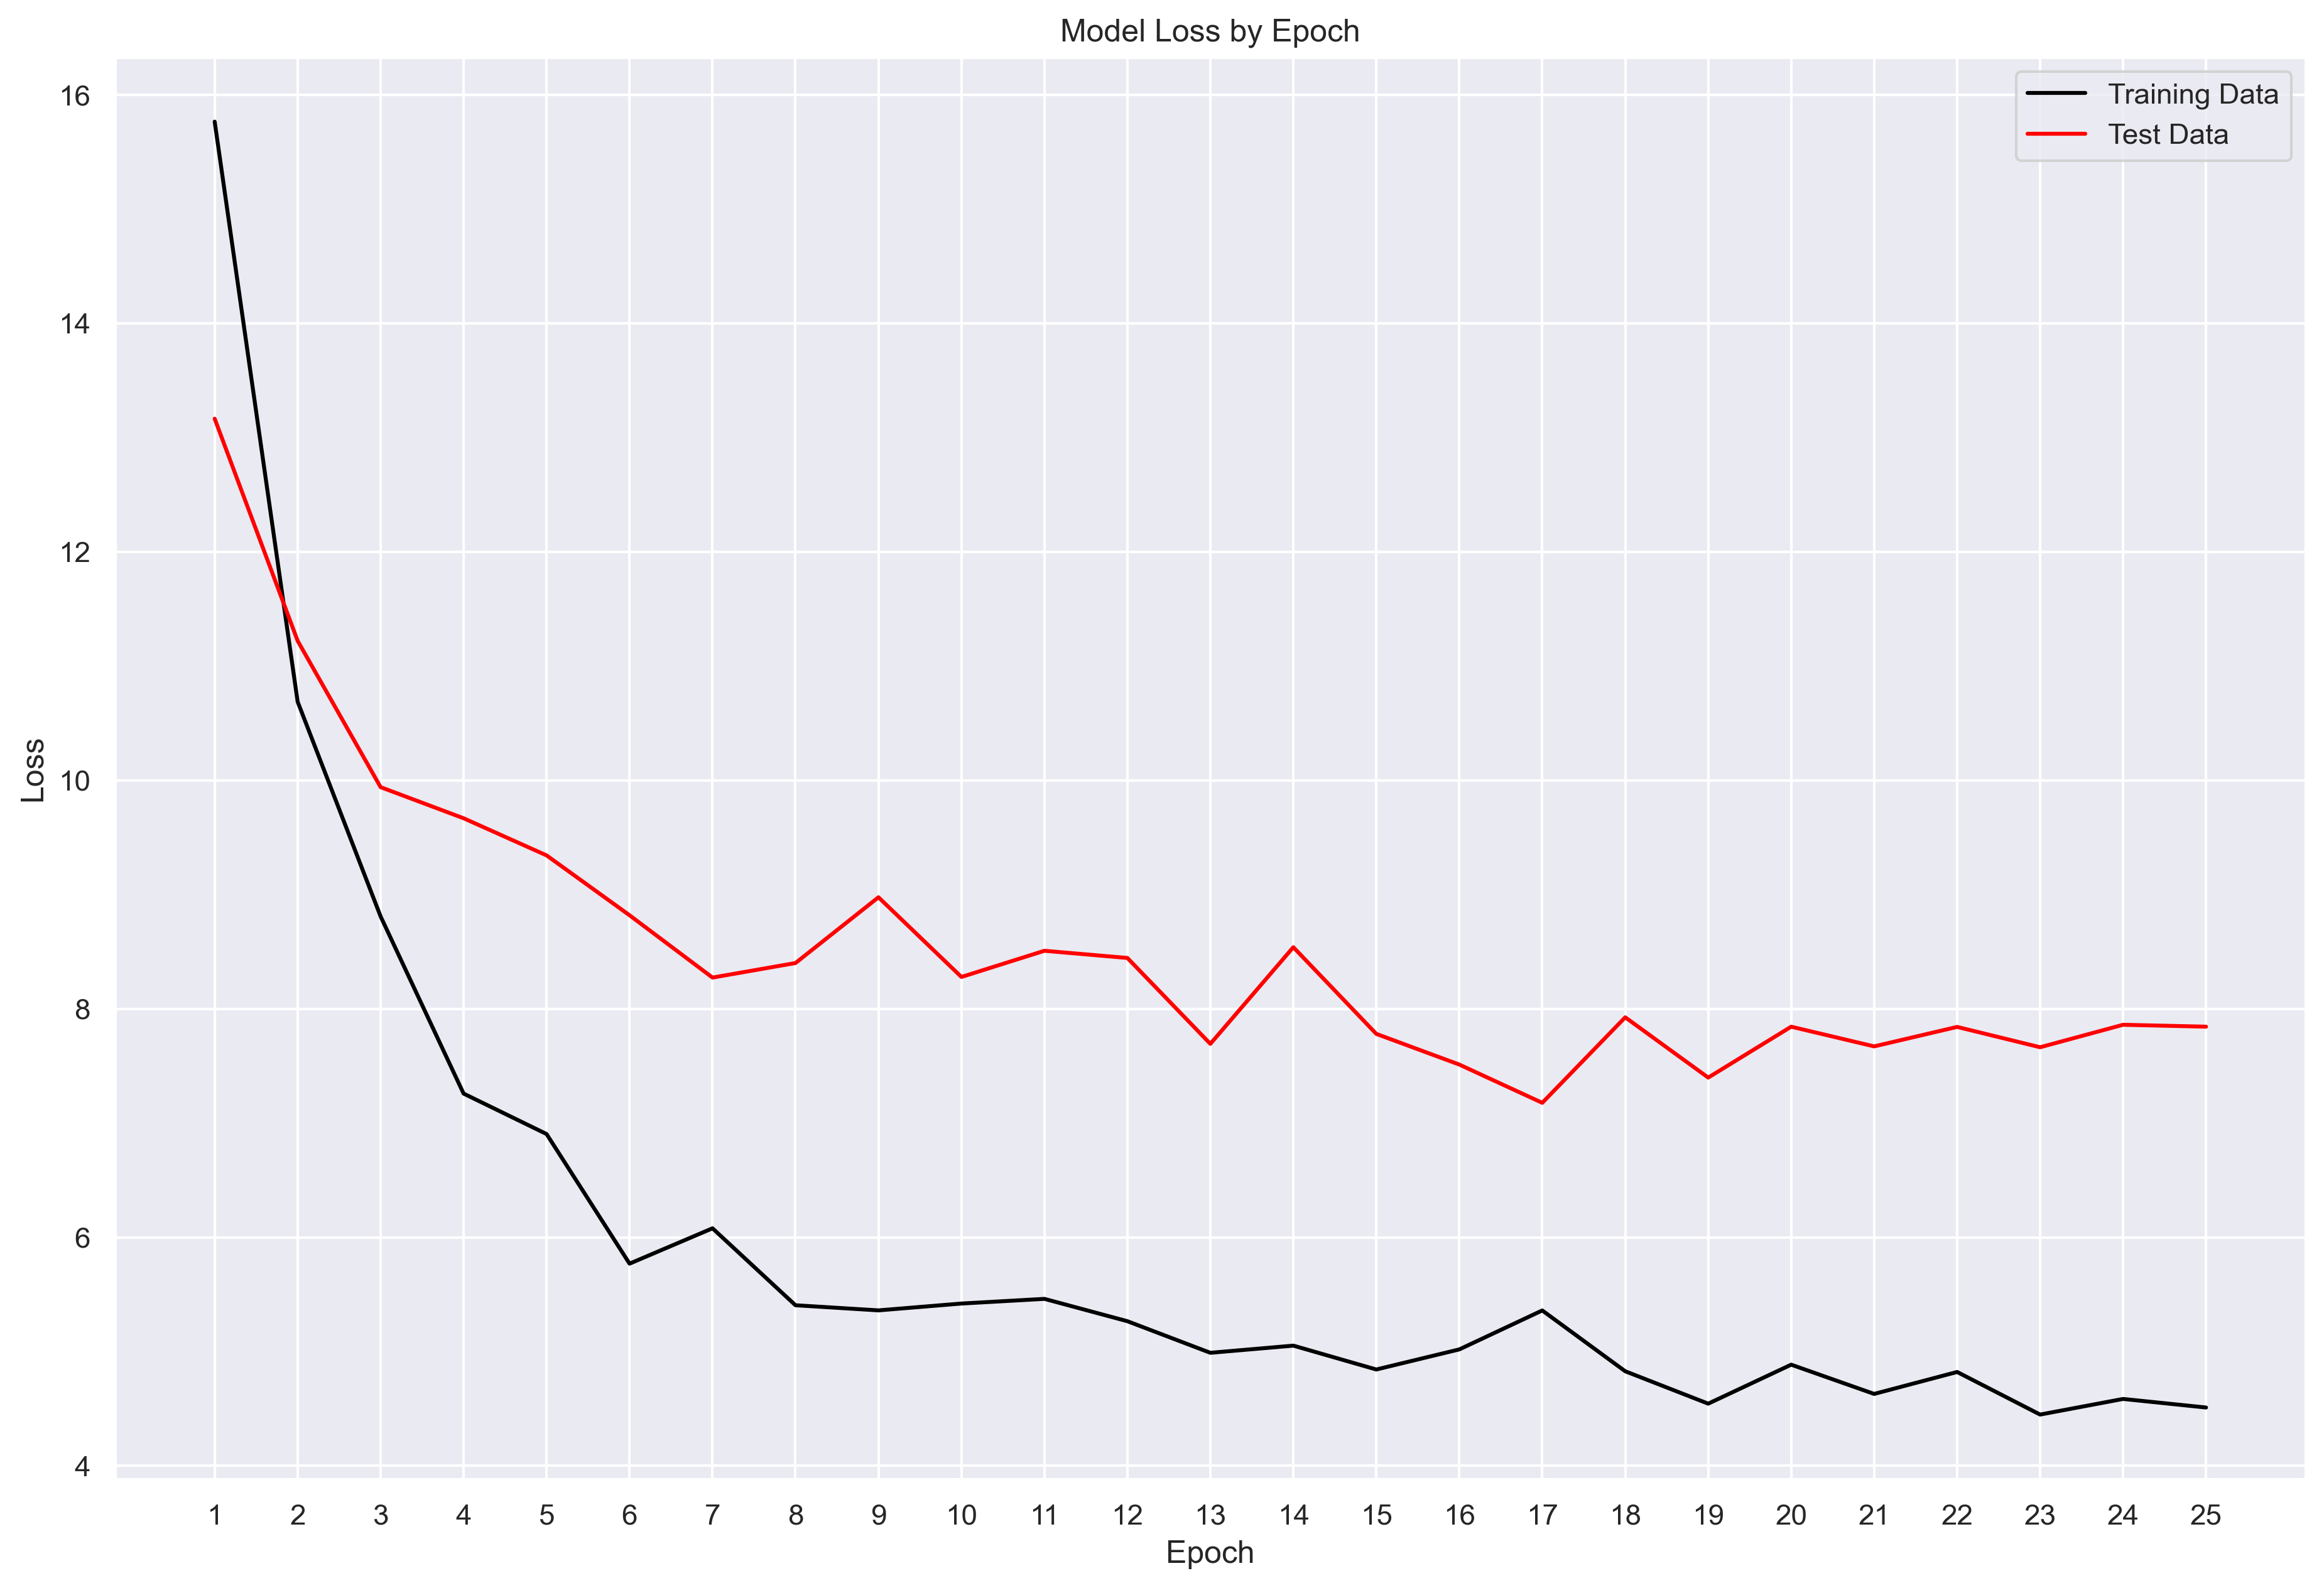

In [394]:
# Model fit
history = vae.fit(X_train_scaled, X_train_scaled, epochs=25, batch_size=16, validation_data=(X_test_scaled, X_test_scaled))

sns.set(rc={'figure.figsize':(20,10)})

# Plot loss over time
fig, ax = plt.subplots(figsize=(15,10), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1));
plt.legend()
plt.show();

### Visualising (2) Latent Dimensions

In [395]:
if latent_dim == 2:
    ## Visualise Latent Space
    plt.style.use('ggplot')

    X_test_encoded = encoder.predict(X_test_scaled)

    colours = {
        1:"r",
        0:"g"
    }

    fig, ax = plt.subplots()
    # encoder returns 3 arrays, z-mean, z-log-sigma, z 
    scatter = ax.scatter(
                        X_test_encoded[2][:,0],
                        X_test_encoded[2][:,1],
                        c=y_test['OverallPoF'].map(colours)
                        )
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("WBA Representation in the 2D Latent Space")
    ax.legend(*scatter.legend_elements(), loc="lower left", title="Overall Pass or Fail")
    plt.show()
else:
    print("Cannot visualise latent space for >2 dimensions.\nNumber of dimensions: {}.".format(latent_dim))

Cannot visualise latent space for >2 dimensions.
Number of dimensions: 32.


Printing sample

In [396]:
if latent_dim == 2:
    ## Generate from latent space
    z_sample = [[-1.8,-0.3]]
    wba_decoded = decoder.predict(z_sample)
    wba_decoded[0]

## Generating Samples from VAE

With the trained VAE, we generate samples. To do this, we generate random numbers (normally distributed with $\mu = 0$, $\sigma = 1$) to map to each latent dimension (distribution). These numbers are used to sample from the latent distributions.

`z_sample` will be a list of lists, with each embedded list having the same number of elements as the number of latent dimensions.

In [397]:
from random import seed
from random import random
from numpy.random import normal

seed(1)

n_samples = 10000
z_sample = []
z_range = 3

for _ in range(n_samples):
  sample = []
  for _ in range(latent_dim):
    sample.append(normal(0,1))
  z_sample.append(sample)

Using the values from `z_sample` to select values from the latent distributions (i.e., generating observations).

In [398]:
# Generate synthetic observations
wba_decoded = decoder.predict(z_sample)

# Convert to dataframe
wba_decoded = pd.DataFrame(wba_decoded, columns = X_train_scaled.columns)

313/313 [==============================] - 1s 4ms/step


### Pre-Preprocessing Reversal

Reversing the normalisation of distirbutions and MinMaxScaler

In [399]:
# Reverse the transformation pre-processing (un-normalisation of distirbutions)
if transform:
    wba_decoded = un_normalise(wba_decoded)

# Reversing MinMaxScaler
if not freqs_only:
    unscaled = scaler.inverse_transform(wba_decoded)
else:
    unscaled = wba_decoded

# Converting to dataframe
gen_df = pd.DataFrame(unscaled, columns = X_train_scaled.columns)

Rounding binary variables to closest whole number.

Binary variables' values can be interpreted as probabilities of having the value of 1 as the neural network maps these values to log likelihoods followed by sigmoid functions.

In [400]:
if not freqs_only:
    for bin_col in bin_cols:
        gen_df[bin_col] = round(gen_df[bin_col])

# Generated Data Assessment

Creating variables to give information to plot titles

In [401]:
if pass_only:
    cond_pass = "Normative Only"
else:
    cond_pass = "Normative + Anomalous"

## Making Long Format

Making long-format dataframes with only frequency variables, for visualisation.

In [402]:
if pass_only:
    gen_freqs_long = gen_df[freq_cols].copy(deep=True)
    gen_freqs_long = gen_freqs_long.melt()

    freqs_long = full_data[freq_cols + ['OverallPoF']].melt('OverallPoF')
    freqs_long = freqs_long[freqs_long['OverallPoF'] == 0]

    gen_freqs_long.columns = ['Frequency', 'Absorbance']
    freqs_long.columns = ['OverallPoF', 'Frequency', 'Absorbance']


else:
    gen_freqs_long = gen_df[freq_cols + ['OverallPoF']].copy(deep=True)
    gen_freqs_long = gen_freqs_long.melt(['OverallPoF'])
    freqs_long = full_data[freq_cols + ['OverallPoF']].melt('OverallPoF')

    gen_freqs_long.columns = ['OverallPoF', 'Frequency', 'Absorbance']
    freqs_long.columns = ['OverallPoF', 'Frequency', 'Absorbance']


## Frequency Distribution Comparison

### Generated Data

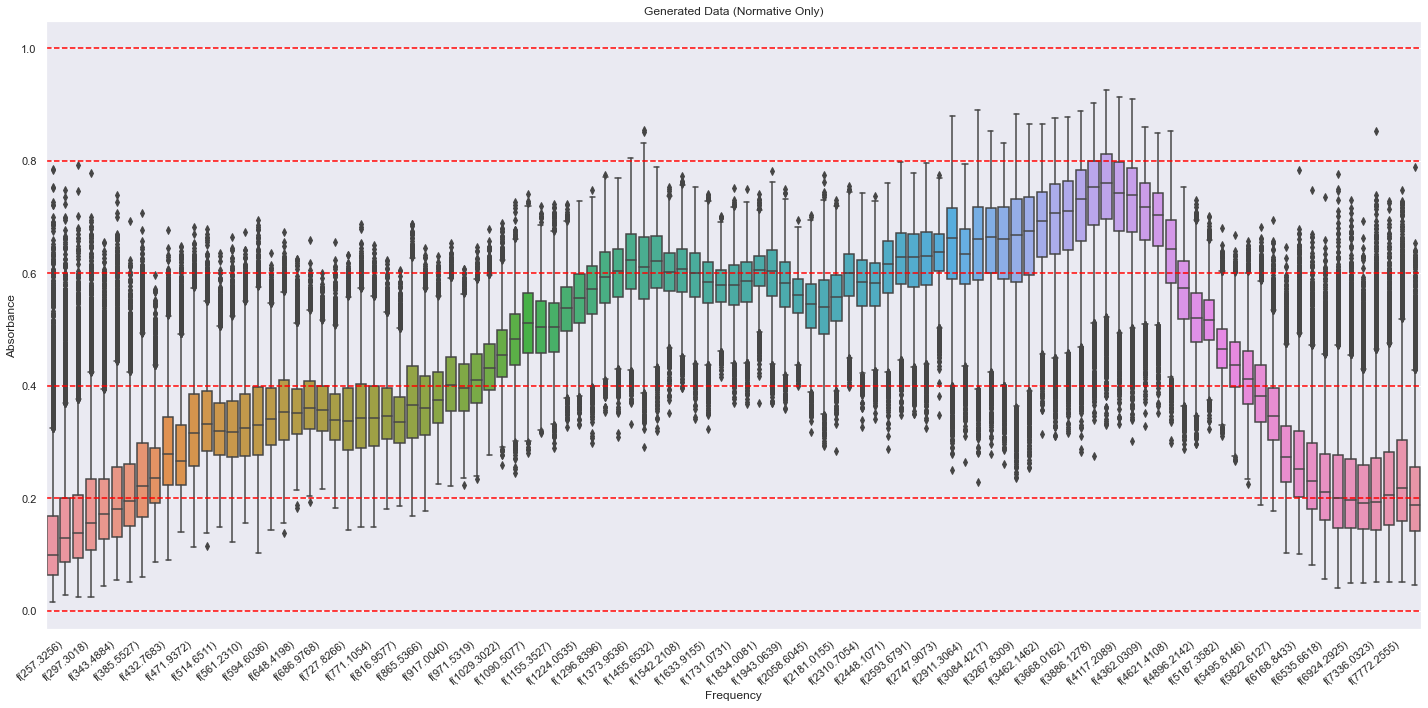

In [403]:
sns.set(rc={'figure.figsize':(20,10)})
ax = sns.boxplot(x="Frequency", y="Absorbance", data=gen_freqs_long)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title='Generated Data ({})'.format(cond_pass))
ax.axhline(1.0, ls='--', color='red')
ax.axhline(0.8, ls='--', color='red')
ax.axhline(0.6, ls='--', color='red')
ax.axhline(0.4, ls='--', color='red')
ax.axhline(0.2, ls='--', color='red')
ax.axhline(0.0, ls='--', color='red')

sns.set(rc={'figure.figsize':(20,10)})
plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.tight_layout()
plt.show();

### Original Data

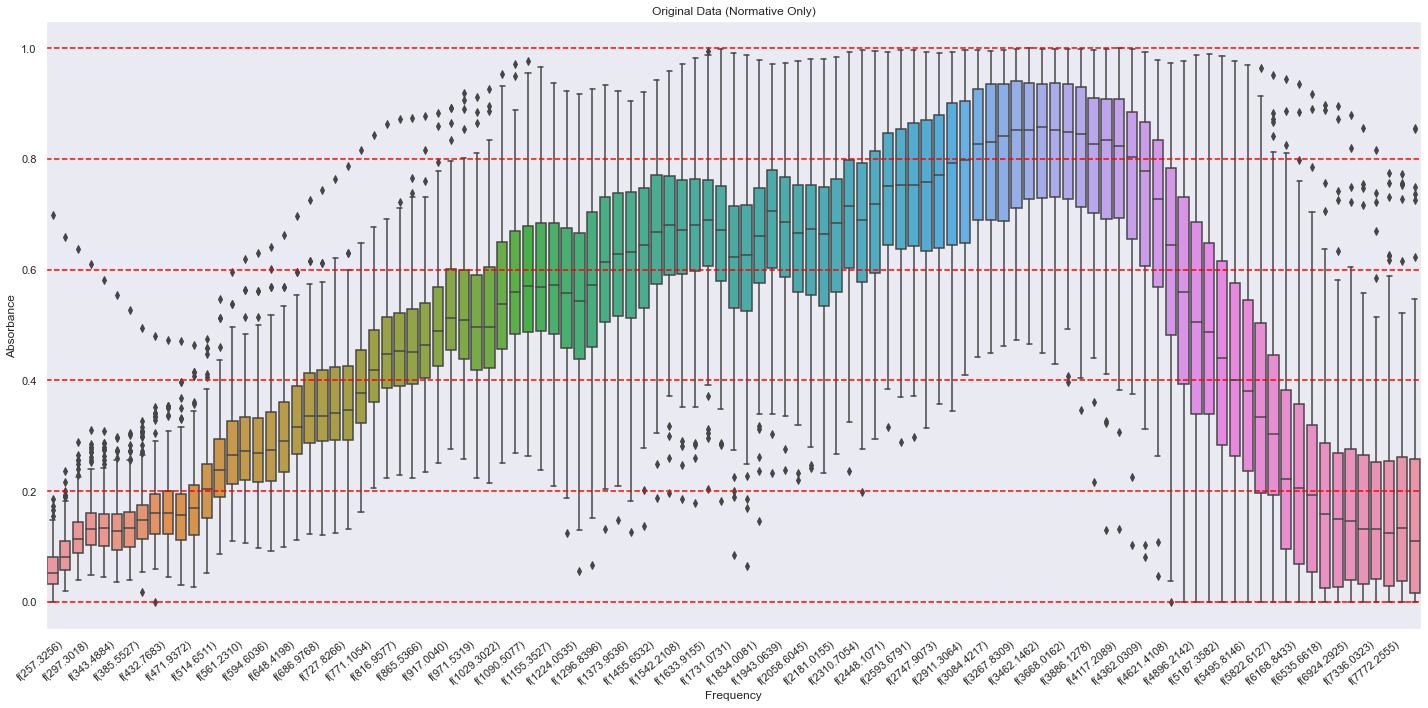

In [404]:
sns.set(rc={'figure.figsize':(20,10)})
ax = sns.boxplot(x="Frequency", y="Absorbance", data=freqs_long)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

ax.set(title='Original Data ({})'.format(cond_pass))

ax.axhline(1.0, ls='--', color='red')
ax.axhline(0.8, ls='--', color='red')
ax.axhline(0.6, ls='--', color='red')
ax.axhline(0.4, ls='--', color='red')
ax.axhline(0.2, ls='--', color='red')
ax.axhline(0.0, ls='--', color='red')

plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.tight_layout()
plt.show();

## Pass/Fail Distribution Comparison

### Generated Data

<ipython-input-405-f45354a000e0>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


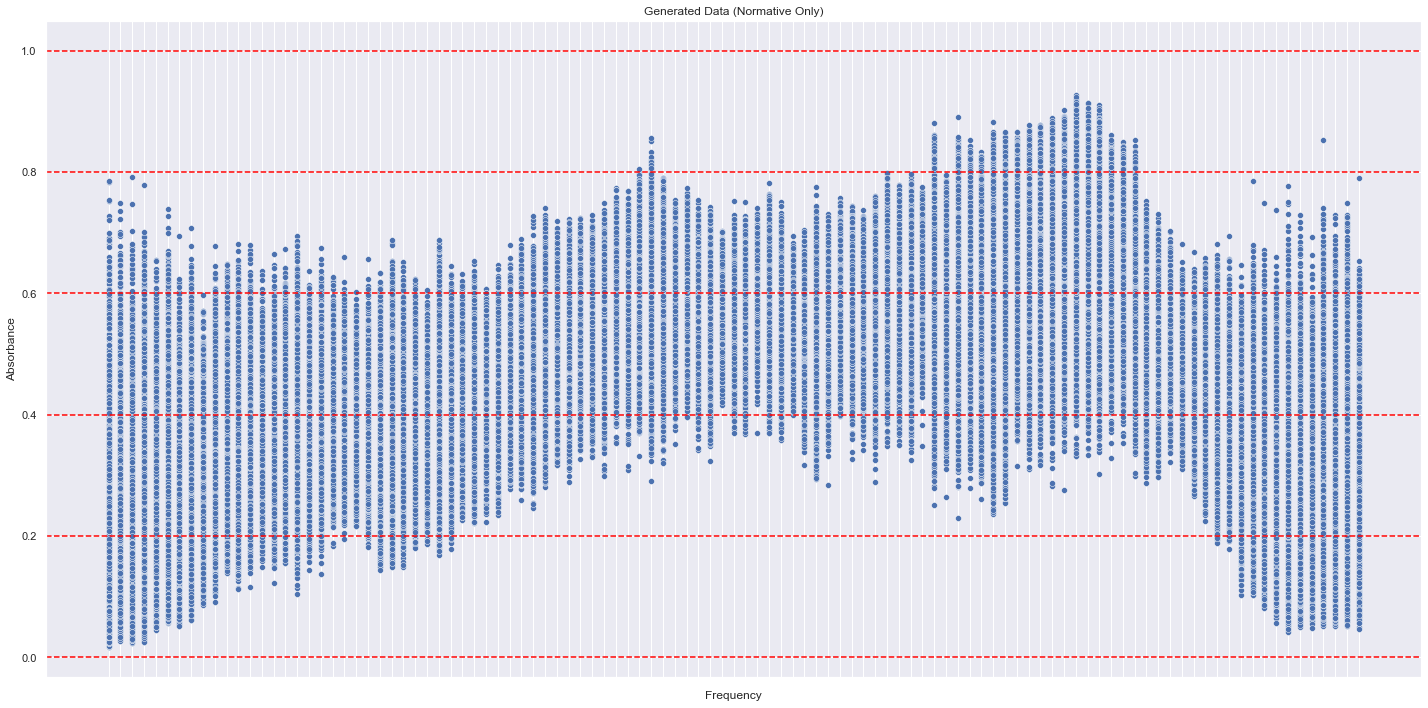

In [405]:
if not pass_only:
    ax = sns.scatterplot(data = gen_freqs_long, x='Frequency', y='Absorbance', hue='OverallPoF')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.set(title="Generated Data ({})".format(cond_pass))
else:
    ax = sns.scatterplot(data = gen_freqs_long, x='Frequency', y='Absorbance')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.set(title="Generated Data ({})".format(cond_pass))

# Horizontal lines
ax.axhline(1, ls='--', color='red')
ax.axhline(0.8, ls='--', color='red')
ax.axhline(0.6, ls='--', color='red')
ax.axhline(0.4, ls='--', color='red')
ax.axhline(0.2, ls='--', color='red')
ax.axhline(0.0, ls='--', color='red')

plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.tight_layout()
plt.show();

### Original Data

<ipython-input-406-1155f6649a9d>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


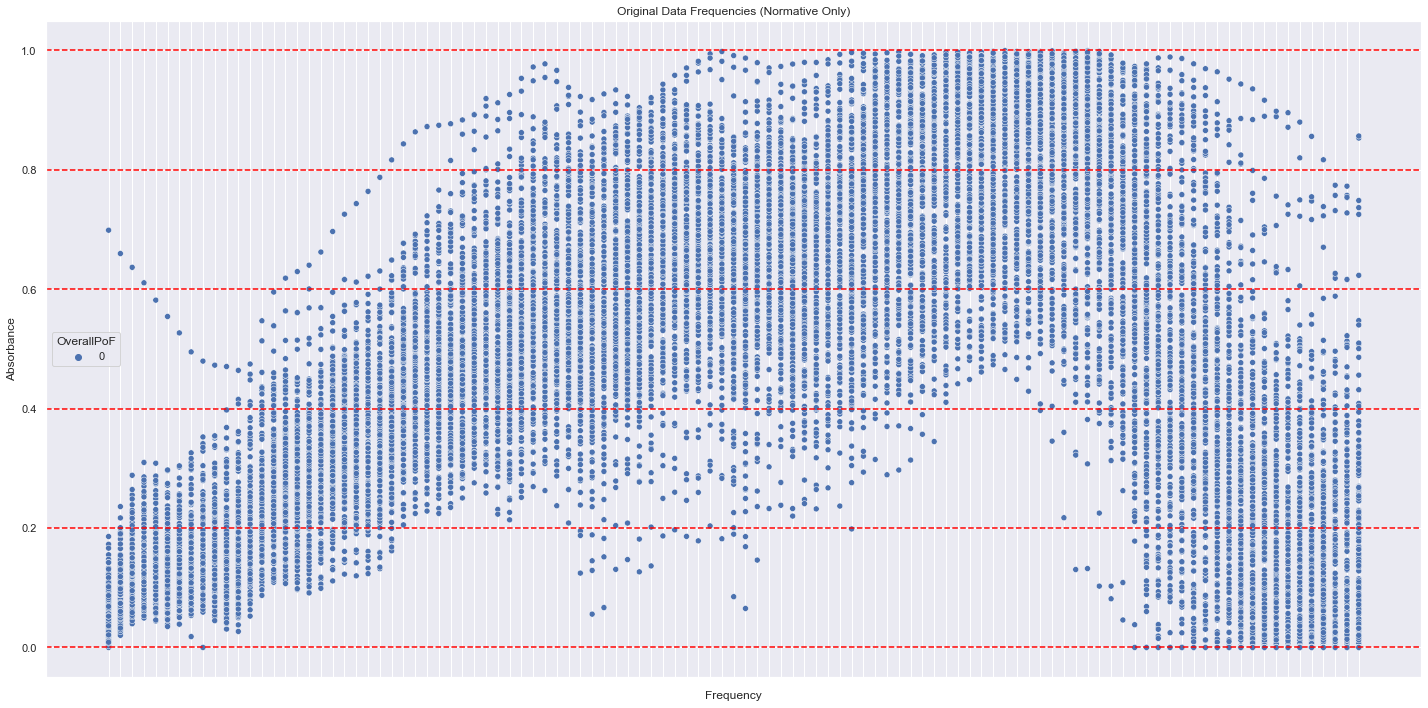

In [406]:
ax = sns.scatterplot(data = freqs_long, x='Frequency', y='Absorbance', hue='OverallPoF')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title="Original Data Frequencies ({})".format(cond_pass))

# Horizontal lines
ax.axhline(1, ls='--', color='red')
ax.axhline(0.8, ls='--', color='red')
ax.axhline(0.6, ls='--', color='red')
ax.axhline(0.4, ls='--', color='red')
ax.axhline(0.2, ls='--', color='red')
ax.axhline(0.0, ls='--', color='red')

plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.tight_layout()
plt.show();

Class counts comparison

In [407]:
if not pass_only:
    print(gen_df['OverallPoF'].value_counts())

In [408]:
print(full_data['OverallPoF'].value_counts())

0    201
1     38
Name: OverallPoF, dtype: int64


## Comparing Control Variables

### Numerical Summaries

In [409]:
if not freqs_only:
    gen_df[cont_cols].describe()

In [410]:
if not freqs_only:
    X[cont_cols].describe()

### Histograms

In [411]:
if not freqs_only:
    gen_df[cont_cols].hist(bins=50, figsize=(20,15))
    plt.show();

In [412]:
if not freqs_only:
    if pass_only:
        X[X['OverallPoF']==0][cont_cols].hist(bins=50, figsize=(20,15))
    else:
        X[cont_cols].hist(bins=50, figsize=(20,15))
    plt.show();

### Creating Balanced Dataframe

Dataframe with the same number of passes and fails.

Commented out by default.\
Uncomment if want to produce a balanced generated dataset, but need to produce a higher number of samples (probably 50000-100000)


In [413]:
# # Rounding DOWN to the nearest 1000 fail observations (e.g. round 2600 down to 2000)
# nearest_1000_down = gen_df['OverallPoF'].value_counts()[1]-gen_df['OverallPoF'].value_counts()[1]%1000

# # Balanced DF consists of `nearest_1000_down` pass and fail observations
# gen_df_balanced = gen_df.groupby('OverallPoF').apply(lambda x: x.sample(nearest_1000_down))

In [414]:
# gen_df_balanced[cont_cols].hist(bins=50, figsize=(20,15))

Splitting into training and test set

In [415]:
# X_gen = gen_df_balanced[cont_cols + freq_cols]
# y_gen = gen_df_balanced['OverallPoF']

In [416]:
# X_gen_train, X_gen_test, y_gen_train, y_gen_test = train_test_split(X_gen, y_gen, test_size=0.1, random_state=1337, stratify=y_gen)

In [417]:
# X_gen_train.to_csv("./X_gen_train.csv")
# X_gen_test.to_csv("./X_gen_test.csv")
# y_gen_train.to_csv("./y_gen_train.csv")
# y_gen_test.to_csv("./y_gen_test.csv")

In [418]:
# gen_df_long.to_csv("gen_df_long.csv")

# Anomaly Detection

For this section, change the `pass_only` option at the top to TRUE.

## Reconstruction Error Threshold

* Used trained model to generate synthetic observations from the original data
* Calculate loss (currently using MSE loss) for each generated observation
* Keep a list of all loss values
    * We will consider an observation anomalous if the reconstruction loss is above some threshold
    * Determine the appropriate threshold by iterating through different thresholds and calculating the performance metric (currently accuracy) for each
    * Select threshold with the highest performance metric score

### Data Transformation

Must select the relevant columns and scale the dataset before the VAE is used to predict (create reconstructions).

In [428]:
## Full data - selecting relevant columns and scaling
full_scaled = pd.DataFrame(scaler.transform(full_data[X.columns]), columns = X.columns)
full_scaled = full_scaled[X_train_scaled.columns]

## Separating fails and passes (for testing purposes)
# Filter out fails
X_fails = full_scaled[full_scaled['OverallPoF'] == 1]

# Filter out passes
X_passes = full_scaled[full_scaled['OverallPoF'] == 0]

# Select relevant columns
X_fails = X_fails[X_train_scaled.columns]

X_passes = X_passes[X_train_scaled.columns]

### Create Variational Reconstructions

`vae.predict(df)` -- Creates variational reconstructions (synthetic observation) of every row of df (assuming same columns as the training set).

In [429]:
# Creating synthetic observations
full_data_pred = pd.DataFrame(vae.predict(full_scaled),columns=X_train_scaled.columns)
full_data_pred_unscaled = pd.DataFrame(scaler.inverse_transform(full_data_pred), columns = X_train_scaled.columns)
full_data_pred_unscaled.head()

8/8 [==============================] - 0s 23ms/step


ValueError: operands could not be broadcast together with shapes (239,108) (121,) (239,108) 

For every row of the synthetic dataset, calculate the loss (MSE).

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

mse_list = []
for idx, row in full_data_pred.iterrows():
    # true = X_passes_scaled.iloc[[idx]].squeeze()
    true = full_scaled[idx]
    mse = mean_squared_error(row, true)
    mse_list.append(mse)
    # print(mse)


We will consider observations anomalous if their reconstruction errors lie outside of the Xth percentile (threshold) of reconstruction errors.\
Iterating through different thresholds (75% to 95%) to see what gives the highest accuracy.

In [ ]:
label_anomalies = full_data['OverallPoF'] == 1
top_acc = 0
top_thresh = 0
for thresh in range(75, 95, 1):
    thresh = thresh/100
    error_thresh = np.quantile(mse_list, thresh)

    pred_anomalies = (mse_list > error_thresh)
    acc = accuracy_score(label_anomalies, pred_anomalies)
    if acc > top_acc:
        top_acc = acc
        top_thresh = thresh
        print("thresh {0}: acc {1}".format(top_thresh, acc))

thresh 0.75: acc 0.8577405857740585
thresh 0.76: acc 0.8661087866108786
thresh 0.77: acc 0.8702928870292888
thresh 0.79: acc 0.8828451882845189
thresh 0.8: acc 0.891213389121339
thresh 0.81: acc 0.899581589958159
thresh 0.82: acc 0.9121338912133892
thresh 0.85: acc 0.9163179916317992
thresh 0.87: acc 0.9288702928870293


Performance metric of the best threshold (in terms of accuracy).

In [ ]:
error_thresh = np.quantile(mse_list, top_thresh)
pred_anomalies = (mse_list > error_thresh)
print(classification_report(label_anomalies, pred_anomalies))

              precision    recall  f1-score   support

       False       0.94      0.98      0.96       201
        True       0.84      0.68      0.75        38

    accuracy                           0.93       239
   macro avg       0.89      0.83      0.86       239
weighted avg       0.93      0.93      0.93       239



In [ ]:
# outpt = decoder(
#     encoder(visible)[2] # Encode the input and take the 3rd element of the output (z-score)
#     )

# ## Loss Function
# r_loss = original_dim * keras.losses.mse(visible, outpt) # MSE loss
# kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1) # KL Divergence
# vae_loss = K.mean(r_loss + kl_loss)

# vae.add_loss(vae_loss)
# vae.compile(optimizer='adam')